In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
from os import listdir
from os.path import isfile, join

In [2]:
# REPORT to DATAFRAME FUNCTIONS
##############################################################################################################

def open_report(file):
    report = open(file).read()
    report = report.split("\n")
    return(report)

##############################################################################################################

def report_resume(report):
    target_symbol = []
    pred_symbol = []
    ID_symbol =[]

    ### get all targets symbols
    to_spell = report[0].split(":")[1]
    to_spell = to_spell[2:-1]

    for i in range(len(to_spell)):
        target_symbol.append(to_spell[i])

    ### extract targets symbols
    for i in range(len(report)):
        if "CORRECTLY guessed" in report[i]:
            pred_symbol.append(report[i].split("'")[-2])
        elif "ERROR: Couldn't guess" in report[i]:
            pred_symbol.append("No Guess")
        elif "Wrongly guessed" in report[i]:
            pred_symbol.append(report[i].split("'")[1])

    ### give ID to target symbols
    for i in range(len(to_spell)):
            ID_symbol.append(i)

    ### get symbols correctly predicted
    is_correct = np.zeros(len(target_symbol))

    for i in range(len(is_correct)):
        if target_symbol[i] == pred_symbol[i]:
            is_correct[i] = 1

    ### create dataframe
    data = {'ID_Symbol': ID_symbol,
            'Target_Symbol': target_symbol,
            'Predict_Symbol': pred_symbol,
            'is_Correct': is_correct
            }

    df = pd.DataFrame(data)

    return(df)

##############################################################################################################

def get_info_per_flash(report,line_flash_start,line_flash_end,symbol_id,seq_flash):
    
    all_probs = []
    all_symbols = []
    probs_symbols = []
    flash_symbols = []

    ### get all symbols / probs per flash
    for i in range(line_flash_start,line_flash_end):
        if "probability" in report[i]:
            all_probs.append(report[i].split(" "))

    ### extract all symbols
    for i in range(len(all_probs)):
        if i == 0:
            all_symbols.append(all_probs[i][-4])
        elif i == 1:
            all_symbols.append(all_probs[i][-3])
        elif i == 2:
            all_symbols.append(" ")
        else:
            all_symbols.append(all_probs[i][-3][1:-1])
    
    if len(all_symbols) == 1:
        all_symbols += ('Backspace', ' ', '!', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '@', 
                        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z')


    ### extract all probs
    for i in range(len(all_probs)):
        probs_symbols.append(float(all_probs[i][-1]))

    if len(all_probs) == 1:
        while len(probs_symbols) < len(all_symbols):
            probs_symbols.append(0)
        
    ### get symbols flashing
    is_flashing = np.zeros(len(all_symbols))

    for i in range(line_flash_start,line_flash_end):
        if "symbols" in report[i]:
            flash_symbols.append(report[i].split(": ")[-1].split(" / "))

    for i in range(len(flash_symbols[0])):
        if flash_symbols[0][i] != 'Backspace':
            flash_symbols[0][i] = flash_symbols[0][i][1:-1]

    for i in range(len(flash_symbols[0])):
        for l in range(len(all_symbols)):
            if flash_symbols[0][i] == all_symbols[l]:
                is_flashing[l] = 1

    ### creating dataframe
    data = {'ID_Symbol': symbol_id,
            '#Flash': seq_flash,
            'Symbol': all_symbols,
            'Probability': probs_symbols,
            'is_Flashing': is_flashing
            }

    df = pd.DataFrame(data)

    return(df)

##############################################################################################################

def report_flashes(report):

    line_flash = []
    seq_flash =[]

    ### get line where flash starts and #flash
    for i in range(len(report)):
        if "flash" in report[i]:
            line_flash.append(i)
            seq_flash.append(int(report[i].split("#")[1].split(" ")[0]))

    line_flash.append(len(report))

    ### get ID_Symbol
    for i in range(len(seq_flash)):
        if i == 0:
            symbol_id = 0
        else:
            if seq_flash[i] < seq_flash[i-1]:
                symbol_id = symbol_id + 1

    ### construct dataframe
        if i == 0:
            df = get_info_per_flash(report,line_flash[i],line_flash[i+1],symbol_id,seq_flash[i])
        else:
            df = df.append(get_info_per_flash(report,line_flash[i],line_flash[i+1],symbol_id,seq_flash[i]))
    
    return(df.reset_index(drop=True))

In [3]:
# BASIC REPORT STATISTICAL ANALYSIS FUNCTIONS
##############################################################################################################

def trial_duration(report):

    line_time =[]

    for i in range(len(report)):
        if ":" in report[i]:
            if not " " in report[i]:
                line_time.append(i)


    start_time = report[line_time[0]].split(":")
    start_time = datetime.time(int(start_time[0]), int(start_time[1]), int(start_time[2]))
    start_time = datetime.datetime.combine(datetime.date.today(), start_time)

    end_time = report[line_time[len(line_time)-1]].split(":")
    end_time = datetime.time(int(end_time[0]), int(end_time[1]), int(end_time[2]))
    end_time = datetime.datetime.combine(datetime.date.today(), end_time)

    return(str(end_time - start_time))

##############################################################################################################

def stat_flash_per_symbol(df,df_resume):
    total_target_is_Flashing = 0
    correct_guess_target_is_Flashing = 0
    wrong_guess_target_is_Flashing = 0
    
    for i in range(len(df_resume)):
        ID_target_symbol = i
        target_symbol = get_target_info_by_ID(df_resume,ID_target_symbol,'Target_Symbol')
        
        df_aux = df[(df['ID_Symbol']==ID_target_symbol) & (df['Symbol']== target_symbol) & (df["is_Flashing"] == 1)]
        to_sum = df_aux[['is_Flashing']].sum()[0]
        total_target_is_Flashing += to_sum
        
        if get_target_info_by_ID(df_resume,ID_target_symbol,'is_Correct') == 1:
            correct_guess_target_is_Flashing += to_sum
        else:
            wrong_guess_target_is_Flashing += to_sum
    
    n_flash_symbol = total_target_is_Flashing/len(df_resume)
    n_flash_symbol_correct = correct_guess_target_is_Flashing/df_resume["is_Correct"].sum()
    n_flash_symbol_not_correct = wrong_guess_target_is_Flashing/(len(df_resume) - df_resume["is_Correct"].sum())

    return(n_flash_symbol, n_flash_symbol_correct, n_flash_symbol_not_correct)

##############################################################################################################

def stat_tgt_symbol_is_flashing_detection(df,df_resume):
    total_target_detection_rate = 0
    correct_guess_target_detection_rate = 0
    wrong_guess_target_detection_rate = 0

    for i in range(len(df_resume)):
        ID_target_symbol = i
        target_symbol = get_target_info_by_ID(df_resume,ID_target_symbol,'Target_Symbol')

        to_sum = Target_Symbol_is_Flashing_detection_rate(df,ID_target_symbol,target_symbol, prt = False)
        total_target_detection_rate += to_sum

        if get_target_info_by_ID(df_resume,ID_target_symbol,'is_Correct') == 1:
            correct_guess_target_detection_rate += to_sum
        else:
            wrong_guess_target_detection_rate += to_sum

    print("Total target_Symbol is_Flashing average detection rate: " + str(round(total_target_detection_rate/len(df_resume),2)))
    print("'Correctly Guessed' target_Symbol is_Flashing average detection rate: " + str(round(correct_guess_target_detection_rate/df_resume["is_Correct"].sum(),2)))
    print("'Not Correctly Guessed' target_Symbol is_Flashing average detection rate: " + str(round(wrong_guess_target_detection_rate/(len(df_resume) - df_resume["is_Correct"].sum()),2)))
    pass

##############################################################################################################

def ITR_calc(duration,n_targets,targets_is_Correct,n_symbols):
    
    classif_accuracy = targets_is_Correct / n_targets
    
    if 1-classif_accuracy == 0:
        B = math.log2(n_symbols) + classif_accuracy * math.log2(classif_accuracy)
    else:
        B = math.log2(n_symbols) + classif_accuracy * math.log2(classif_accuracy) + (1-classif_accuracy) * math.log2((1-classif_accuracy)/(n_symbols-1))
        
    Q = n_targets / duration
    
    return(round(B*Q,2))

##############################################################################################################

def trial_duration_in_minutes(trial_dur):
    
    hours_secs = int(trial_dur.split(":")[0])*60*60
    mins_secs = int(trial_dur.split(":")[1])*60
    secs = int(trial_dur.split(":")[2])
    
    trial_dur_mins = (hours_secs + mins_secs + secs)/60
    
    return(trial_dur_mins)

##############################################################################################################

def report_stats(report, full_report = True):
    
    df = report_flashes(report)
    df_resume = report_resume(report)

    #trial duration
    trial_dur = trial_duration(report)
    print("Trial duration: " + str(trial_dur))

    #quantity of symbols
    print("# of symbols to spell: " + str(len(df_resume)))

    #% correctly guessed
    print("'Correctly Guessed' symbols rate: " + str(round(df_resume["is_Correct"].sum()/len(df_resume),2)))
    
    #correctly guessed symbols per minute
    trial_dur_mins = trial_duration_in_minutes(trial_dur)  
    print("'Correctly Guessed' symbols / minute: " + str(round(df_resume["is_Correct"].sum()/trial_dur_mins,2)))
    
    #ITR
    ITR = ITR_calc(trial_dur_mins,len(df_resume),df_resume["is_Correct"].sum(),P300_symbols)
    print("Information Transfer Rate (ITR) [bits / minute]: " + str(ITR))
    
    print(" ")

    #Average # of flashes per symbol
    n_flash_symbol, n_flash_symbol_correct, n_flash_symbol_not_correct = stat_flash_per_symbol(df,df_resume)
    
    print("Average # of flashes per symbol: " + str(round(n_flash_symbol,2)))
    print("Average # of flashes per symbol 'Correctly Guessed': " + str(round(n_flash_symbol_correct,2)))
    print("Average # of flashes per symbol 'Not Correctly Guessed': " + str(round(n_flash_symbol_not_correct,2)))


    print(" ")
    
    if full_report == True:
        #Target_Symbol is_Flashing average detection rate
        stat_tgt_symbol_is_flashing_detection(df,df_resume)
    
    pass

##############################################################################################################

def report_stats_consolidated(path):
    
    report_list = [f for f in listdir(path) if isfile(join(path, f))]
    
    if '.DS_Store' in report_list:
        report_list.remove('.DS_Store')
    
    df_stats_consolidated = pd.DataFrame(columns=['Participant', 
                                                  'Trial_Duration', 
                                                  'Symbols_to_Spell', 
                                                  'Correctly_Guessed_rate', 
                                                  'Correctly_Guessed_Symbol_per_Minute',
                                                  'ITR', 
                                                  'Flashes_per_Symbol', 
                                                  'Flashes_per_Symbol_Correctly_Guessed', 
                                                  'Flashes_per_Symbol_not_Correctly_Guessed'])
    
    for i in range(len(report_list)):
        report = open_report(path + str(report_list[i]))
        
        df = report_flashes(report)
        df_resume = report_resume(report)
        
        participant = report_list[i].split("_")[1:]
        trial_dur = trial_duration(report)
        symbols_to_spell = len(df_resume)
        correct_guessed_symbols = round(df_resume["is_Correct"].sum()/len(df_resume),2)
        trial_dur_mins = trial_duration_in_minutes(trial_dur) 
        correct_guessed_symbols_min = round(df_resume["is_Correct"].sum()/trial_dur_mins,2)
        ITR = ITR_calc(trial_dur_mins,len(df_resume),df_resume["is_Correct"].sum(),P300_symbols)
        n_flash_symbol, n_flash_symbol_correct, n_flash_symbol_not_correct = stat_flash_per_symbol(df,df_resume)
        
        df_stats_consolidated = df_stats_consolidated.append({'Participant': participant, 
                                                              'Trial_Duration': trial_dur, 
                                                              'Symbols_to_Spell': symbols_to_spell, 
                                                              'Correctly_Guessed_rate': correct_guessed_symbols, 
                                                              'Correctly_Guessed_Symbol_per_Minute': correct_guessed_symbols_min,
                                                              'ITR': ITR, 
                                                              'Flashes_per_Symbol': n_flash_symbol, 
                                                              'Flashes_per_Symbol_Correctly_Guessed': n_flash_symbol_correct, 
                                                              'Flashes_per_Symbol_not_Correctly_Guessed': n_flash_symbol_not_correct},
                                                             ignore_index=True)
        
        
    df_stats_consolidated = df_stats_consolidated.sort_values(by=['Participant'])
        
    print("CONSOLIDATED METRICS (Average)")
    print("")
    print(round(df_stats_consolidated.mean(),3))
    print("")
    
    print("CONSOLIDATED METRICS (Standard Deviation)")
    print("")
    print(round(df_stats_consolidated.std(),3))
    
    return(df_stats_consolidated)


In [4]:
# AUX FUNCTIONS
##############################################################################################################

def most_relevant_symbols(df,id_symbol):
    symbols = df[['Symbol']].drop_duplicates().to_numpy()
    mean_vector = np.zeros(len(symbols))


    for i in range(len(symbols)):
        aux = df[(df['ID_Symbol']==id_symbol) & (df['Symbol']==symbols[i][0])]
        mean_vector[i] = aux[['Probability']].mean()[0]

    data = {'Symbol': symbols[:,0],
            'Mean_prob': mean_vector,
            }

    df = pd.DataFrame(data)
    #df.sort_values('Mean_prob', ascending=False)

    df = df[(df['Mean_prob']>=0.05) & (df['Symbol']!='classification')].to_numpy()[:,0]

    return(df)

##############################################################################################################

def get_target_info_by_ID(data,ID,column_to_return):

    data = data[(data['ID_Symbol']==ID)]
    data = data[[column_to_return]].to_numpy()
    
    if column_to_return == 'is_Correct':
        to_return = int(data[0][0])
    else:
        to_return = data[0][0]
        
    return(to_return)

##############################################################################################################

def Target_Symbol_is_Flashing_detection_rate(df,ID_target_symbol,target_symbol, prt = True):
    df_aux = df[(df['ID_Symbol']==ID_target_symbol) & (df['Symbol']==target_symbol)]

    count = 0
    detected = 0

    for i in range(len(df_aux)):
        if df_aux['is_Flashing'].iloc[i] == 1:
            count += 1
            
            if i == 0:
                if df_aux['Probability'].iloc[i] > 0.0276075:
                    detected += 1
                    
            else:
                if df_aux['Probability'].iloc[i] > df_aux['Probability'].iloc[i-1]:
                    detected += 1
    if prt == True:           
        print("Target_Symbol is_Flashing detection rate: " + str(round(detected / count,2)))
        
    return(detected / count)

##############################################################################################################

def Classification_prob_avg_flash_detection(df,ID_target_symbol,target_symbol):
    df_classification = df[(df['ID_Symbol']==ID_target_symbol) & (df['Symbol']=='classification')]
    df_symbol = df[(df['ID_Symbol']==ID_target_symbol) & (df['Symbol']==target_symbol)]


    detected = 0
    classification_rate_detected = 0
    not_detected = 0
    classification_rate_not_detected = 0

    for i in range(len(df_symbol)):
        classification = df_classification['Probability'].iloc[i]

        if df_symbol['is_Flashing'].iloc[i] == 1:

            if i == 0:
                if df_symbol['Probability'].iloc[i] > 0.0276075:
                    detected += 1
                    classification_rate_detected += classification
                else:
                    not_detected += 1
                    classification_rate_not_detected += classification

            else:
                if df_symbol['Probability'].iloc[i] > df_symbol['Probability'].iloc[i-1]:
                    detected += 1
                    classification_rate_detected += classification

                else:
                    not_detected += 1
                    classification_rate_not_detected += classification
                    
    if detected == 0:
        detected_to_print = 0
    else:
        detected_to_print = round(classification_rate_detected / detected,2)
    
    if not_detected == 0:
        not_detected_to_print = 0
    else:
        not_detected_to_print = round(classification_rate_not_detected / not_detected,2)
        
    print("Classification average probability when flash detected: " + str(detected_to_print))
    print("Classification average probability when flash NOT detected: " + str(not_detected_to_print))
    pass

In [5]:
# GRAPH FUNCTIONS
##############################################################################################################

def graph_target_symbol_prob_flashes(df,ID_target_symbol,target_symbol,symbol_to_visualize,guessed_Symbol=[]):

    #plot probs
    for i in range(len(symbol_to_visualize)):
        to_plot = df[(df['ID_Symbol']==ID_target_symbol) & (df['Symbol']==symbol_to_visualize[i])]
        to_plot = to_plot[['Probability']].reset_index(drop=True)

        plt.plot(to_plot, label=symbol_to_visualize[i])

    #plot flashs
    to_plot = df[(df['ID_Symbol']==ID_target_symbol) & (df['Symbol']== target_symbol) & (df["is_Flashing"] == 1)]
    to_plot = to_plot[['#Flash']].reset_index(drop=True)
    to_plot = to_plot.to_numpy()
    
    count_flash = 0
    for i in range(len(to_plot)):
        plt.axvline(x=to_plot[i], linestyle=":", color="gray")
        count_flash += 1
        
    plt.plot([], [], ' ', label="is_Flashing (" + str(count_flash) + ")", linestyle=":", color="gray")

    #add legend
    plt.legend(title='Symbol')

    #add axes labels and a title
    if guessed_Symbol == []:
        plt.title('Target Symbol: ' + target_symbol, fontsize=16)
    else:
        plt.title('Target Symbol: ' + target_symbol + ' / Guessed Symbol: ' + guessed_Symbol, fontsize=16)
        
    plt.ylabel('Probability of predict', fontsize=14)
    plt.xlabel('#Flash', fontsize=14)

    #display plot
    plt.show()
    
    pass

In [6]:
data_path = '/Users/guilhermesantos/Downloads/Reports_data/Dry_Electrodes/'
participant = '_01'
#participants: _01, _02, _03, _04, _05, _06, _07, _08, _09, _10
data_file = 'report' + participant

full_report = True
P300_symbols = 44

report = open_report(data_path + data_file)

#Consolidated
dry_electrodes_path = '/Users/guilhermesantos/Downloads/Reports_data/Dry_Electrodes/'
report_stats_consolidated(dry_electrodes_path)

<ipython-input-3-ddb0b23cec75>:46: RuntimeWarning: invalid value encountered in double_scalars
  n_flash_symbol_not_correct = wrong_guess_target_is_Flashing/(len(df_resume) - df_resume["is_Correct"].sum())
<ipython-input-3-ddb0b23cec75>:46: RuntimeWarning: invalid value encountered in double_scalars
  n_flash_symbol_not_correct = wrong_guess_target_is_Flashing/(len(df_resume) - df_resume["is_Correct"].sum())


CONSOLIDATED METRICS (Average)

Symbols_to_Spell                             9.200
Correctly_Guessed_rate                       0.818
Correctly_Guessed_Symbol_per_Minute          2.608
ITR                                         12.519
Flashes_per_Symbol                          12.277
Flashes_per_Symbol_Correctly_Guessed        11.296
Flashes_per_Symbol_not_Correctly_Guessed    17.188
dtype: float64

CONSOLIDATED METRICS (Standard Deviation)

Symbols_to_Spell                            2.741
Correctly_Guessed_rate                      0.110
Correctly_Guessed_Symbol_per_Minute         0.924
ITR                                         5.943
Flashes_per_Symbol                          1.974
Flashes_per_Symbol_Correctly_Guessed        1.625
Flashes_per_Symbol_not_Correctly_Guessed    2.298
dtype: float64


,Participant,Trial_Duration,Symbols_to_Spell,Correctly_Guessed_rate,Correctly_Guessed_Symbol_per_Minute,ITR,Flashes_per_Symbol,Flashes_per_Symbol_Correctly_Guessed,Flashes_per_Symbol_not_Correctly_Guessed
8,[01],0:01:14,6,1.00,4.86,26.56,7.333333,7.333333,NaN
4,[02],0:03:00,9,0.89,2.67,13.06,12.666667,12.000000,18.0
1,[03],0:04:08,11,0.73,1.94,8.34,13.909091,12.375000,18.0
2,[04],0:02:17,7,0.71,2.19,9.34,12.285714,10.000000,18.0
3,[05],0:03:49,11,0.82,2.36,10.92,12.818182,11.666667,18.0
9,[06],0:05:00,14,0.79,2.20,9.93,13.071429,11.727273,18.0
5,[07],0:02:35,7,0.71,1.94,8.25,13.714286,12.000000,18.0
7,[08],0:03:02,9,0.78,2.31,10.35,12.555556,12.857143,11.5
6,[09],0:01:41,6,1.00,3.56,19.46,10.666667,10.666667,NaN
0,[10],0:04:24,12,0.75,2.05,8.98,13.750000,12.333333,18.0


In [7]:
report_resume(report)

,ID_Symbol,Target_Symbol,Predict_Symbol,is_Correct
0,0,J,J,1.0
1,1,U,U,1.0
2,2,S,S,1.0
3,3,T,T,1.0
4,4,I,I,1.0
5,5,N,N,1.0


In [8]:
report_flashes(report)

,ID_Symbol,#Flash,Symbol,Probability,is_Flashing
0,0,0,classification,0.044252,0.0
1,0,0,Backspace,0.027787,0.0
2,0,0,,0.027787,0.0
3,0,0,!,0.027787,0.0
4,0,0,',0.027787,0.0
...,...,...,...,...,...
9535,5,26,V,0.000017,0.0
9536,5,26,W,0.002600,0.0
9537,5,26,X,0.000001,0.0
9538,5,26,Y,0.000304,0.0


In [9]:
report_stats(report, full_report = full_report)

Trial duration: 0:01:14
# of symbols to spell: 6
'Correctly Guessed' symbols rate: 1.0
'Correctly Guessed' symbols / minute: 4.86
Information Transfer Rate (ITR) [bits / minute]: 26.56
 
Average # of flashes per symbol: 7.33
Average # of flashes per symbol 'Correctly Guessed': 7.33
Average # of flashes per symbol 'Not Correctly Guessed': nan
 
Total target_Symbol is_Flashing average detection rate: 0.46
'Correctly Guessed' target_Symbol is_Flashing average detection rate: 0.46
'Not Correctly Guessed' target_Symbol is_Flashing average detection rate: nan


<ipython-input-3-ddb0b23cec75>:46: RuntimeWarning: invalid value encountered in double_scalars
  n_flash_symbol_not_correct = wrong_guess_target_is_Flashing/(len(df_resume) - df_resume["is_Correct"].sum())
<ipython-input-3-ddb0b23cec75>:71: RuntimeWarning: invalid value encountered in double_scalars
  print("'Not Correctly Guessed' target_Symbol is_Flashing average detection rate: " + str(round(wrong_guess_target_detection_rate/(len(df_resume) - df_resume["is_Correct"].sum()),2)))


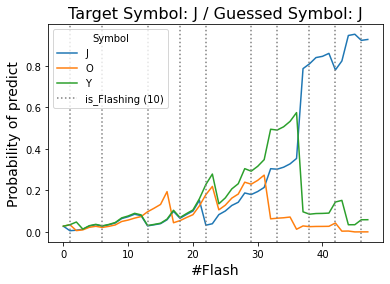

Target_Symbol is_Flashing detection rate: 0.1
Classification average probability when flash detected: 0.54
Classification average probability when flash NOT detected: 0.3


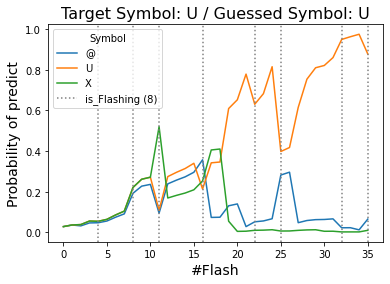

Target_Symbol is_Flashing detection rate: 0.25
Classification average probability when flash detected: 0.85
Classification average probability when flash NOT detected: 0.23


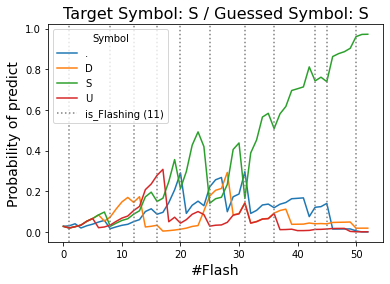

Target_Symbol is_Flashing detection rate: 0.18
Classification average probability when flash detected: 0.7
Classification average probability when flash NOT detected: 0.29


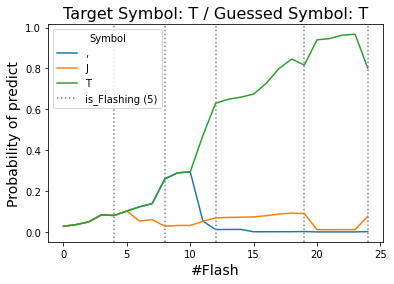

Target_Symbol is_Flashing detection rate: 0.4
Classification average probability when flash detected: 0.87
Classification average probability when flash NOT detected: 0.29


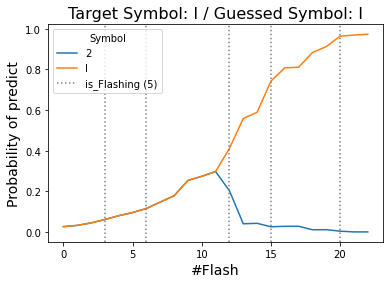

Target_Symbol is_Flashing detection rate: 1.0
Classification average probability when flash detected: 0.68
Classification average probability when flash NOT detected: 0


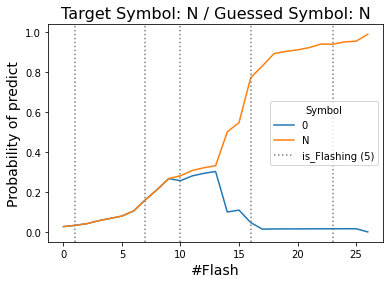

Target_Symbol is_Flashing detection rate: 0.8
Classification average probability when flash detected: 0.64
Classification average probability when flash NOT detected: 0.49


In [10]:
df = report_flashes(report)
df_resume = report_resume(report)

for i in range(len(df_resume)):
    ID_target_symbol = i
    target_symbol = get_target_info_by_ID(df_resume,ID_target_symbol,'Target_Symbol')
    symbol_to_visualize = np.unique(np.append(most_relevant_symbols(df,ID_target_symbol),target_symbol))
    graph_target_symbol_prob_flashes(df,ID_target_symbol,target_symbol,symbol_to_visualize,guessed_Symbol=get_target_info_by_ID(df_resume,ID_target_symbol,'Predict_Symbol'))
    
    if full_report == True:
        Target_Symbol_is_Flashing_detection_rate(df,ID_target_symbol,target_symbol)
        Classification_prob_avg_flash_detection(df,ID_target_symbol,target_symbol)